In [19]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import imutils
import random
import pickle

#import ML libraries and framework
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer

from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing.image import img_to_array

# model and layers
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras import backend as K


In [4]:
# Define the dataset path and other constants.
EPOCHS = 10
LEARNING_RATE = 1e-3 # default value for Adam Optimizer
BATCH_SIZE = 32
IMAGE_DIMENSIONS = (150, 150, 3)
DATASET_DIR = 'multi-label-dataset'
CURR_DIR = os.getcwd()
TRAIN_CSV = 'train.csv'
LABEL_DICT = {'dmg': 'damage', 'whl': 'whole', 'mnr': 'minor', 'mod': 'moderate', 'svr': 'severe', 'frt': 'front', 'rr': 'rear', 'sd': 'side'}
print(CURR_DIR)

/Users/ravisher/Development/FatehLabs/AIDD-Project


In [5]:
train_csv = pd.read_csv(os.path.join(CURR_DIR, TRAIN_CSV))
print('Shape => ', train_csv.shape)
print('Head => ', train_csv.head())
print('Columns => ', train_csv.columns)

Shape =>  (3798, 10)
Head =>        Image Classification  Damage  Whole  Front  Rear  Side  Minor  Major  \
0  dmg_0001     ['Damage']       1      0      0     0     0      0      0   
1  dmg_0002     ['Damage']       1      0      0     0     0      0      0   
2  dmg_0003     ['Damage']       1      0      0     0     0      0      0   
3  dmg_0004     ['Damage']       1      0      0     0     0      0      0   
4  dmg_0005     ['Damage']       1      0      0     0     0      0      0   

   Severe  
0       0  
1       0  
2       0  
3       0  
4       0  
Columns =>  Index(['Image', 'Classification', 'Damage', 'Whole', 'Front', 'Rear', 'Side',
       'Minor', 'Major', 'Severe'],
      dtype='object')


In [6]:
images = []
dataset_path = os.path.join(CURR_DIR, DATASET_DIR)
print('Dataset path: ', dataset_path)
for idx in range(train_csv.shape[0]):
    img_name = train_csv["Image"][idx] + '.jpeg'
    images.append(os.path.join(dataset_path, img_name))

Dataset path:  /Users/ravisher/Development/FatehLabs/AIDD-Project/multi-label-dataset


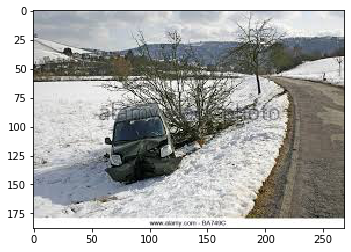

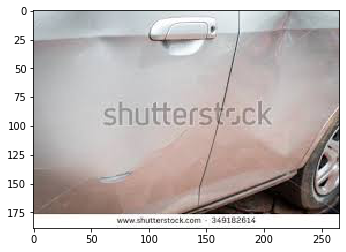

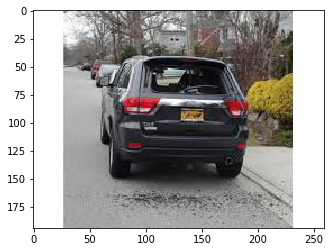

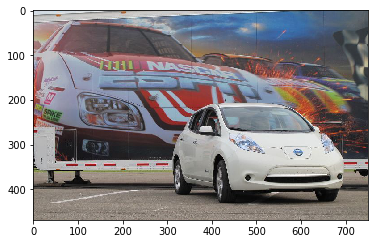

In [7]:
random.shuffle(images)
import matplotlib.image as mpimg
for img in images[:4]:
    image = mpimg.imread(img)
    implot = plt.imshow(image)
    plt.show()

In [8]:
from keras.preprocessing.image import img_to_array
data = []
labels = []
for img in images:
    # load the image, pre-process it and store it in the data list    
    image = cv2.imread(img)    
    image = cv2.resize(image, (IMAGE_DIMENSIONS[1], IMAGE_DIMENSIONS[0]))
    image = img_to_array(image)
    data.append(image)
    l = label = img.split(os.path.sep)[-1].split('_')[0]
    value = LABEL_DICT[l]
    if(value in ['minor', 'moderate', 'severe', 'front', 'rear', 'side']):
        labels.append(['damage', value])
    else:
        labels.append([value])
    

In [9]:
data = np.array(data, dtype='float') / 255.0
labels = np.array(labels)
print('Image Shape: ', data.shape)
print('Label Shape: ', labels.shape)

Image Shape:  (3798, 150, 150, 3)
Label Shape:  (3798,)


In [11]:
# Binarize the labels using the scikit-learn's multi-label binarizer implementation
mlb = MultiLabelBinarizer()
labels = mlb.fit_transform(labels)

In [12]:
print(mlb.classes_)

['damage' 'front' 'minor' 'moderate' 'rear' 'severe' 'side' 'whole']


In [13]:
# Training Testing Split
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.2, random_state=42)

In [14]:
# construct the image generator for data augmentation
aug = ImageDataGenerator(rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
    horizontal_flip=True, fill_mode="nearest")

In [15]:
# Build the model
def build(width, height, depth, classes, final_act="softmax"):
        # initialize the model along with the input shape
        model = Sequential()
        inputShape = (height, width, depth)
        channel_dim = -1

        if K.image_data_format() == "channels_first":
            inputShape = (depth, height, width)
            channel_dim = 1

        # CONV => RELU => POOL
        model.add(Conv2D(32, (3, 3), padding="same", input_shape=inputShape))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=channel_dim))
        model.add(MaxPooling2D(pool_size=(3, 3)))
        model.add(Dropout(0.25))

	# (CONV => RELU) * 2 => POOL
        model.add(Conv2D(64, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=channel_dim))
        model.add(Conv2D(64, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=channel_dim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))

	# (CONV => RELU) * 2 => POOL
        model.add(Conv2D(128, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=channel_dim))
        model.add(Conv2D(128, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=channel_dim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))

        #FC => RELU layers
        model.add(Flatten())
        model.add(Dense(1024))
        model.add(Activation("relu"))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

	    # use a *softmax* activation for single-label classification
	    # and *sigmoid* activation for multi-label classification
        model.add(Dense(classes))
        model.add(Activation(final_act))

	    # return the constructed network architecture
        return model

In [16]:
# Build and compile the model
model = build(width=IMAGE_DIMENSIONS[1], height=IMAGE_DIMENSIONS[0], depth=IMAGE_DIMENSIONS[2], classes=len(mlb.classes_), final_act="sigmoid")
opt = Adam(lr=LEARNING_RATE, decay=LEARNING_RATE/EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])
print(model.summary())

W1103 09:43:30.078704 4598752704 deprecation_wrapper.py:119] From /Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4070: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W1103 09:43:32.052937 4598752704 deprecation.py:323] From /Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 150, 150, 32)      896       
_________________________________________________________________
activation_1 (Activation)    (None, 150, 150, 32)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 150, 150, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 50, 50, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 50, 64)        18496     
_________________________________________________________________
activation_2 (Activation)    (None, 50, 50, 64)       

In [17]:
# Training Starts
H = model.fit_generator(aug.flow(trainX, trainY, batch_size=BATCH_SIZE), validation_data=(testX, testY),
                        steps_per_epoch=len(trainX) // BATCH_SIZE, epochs=EPOCHS, verbose=1)

W1103 09:43:44.681434 4598752704 deprecation_wrapper.py:119] From /Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:422: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



Epoch 1/10
94/94 [==============================] - 304s 3s/step - loss: 0.6341 - accuracy: 0.7078 - val_loss: 0.4767 - val_accuracy: 0.8732
Epoch 2/10
94/94 [==============================] - 255s 3s/step - loss: 0.3704 - accuracy: 0.8750 - val_loss: 0.9693 - val_accuracy: 0.8732
Epoch 3/10
94/94 [==============================] - 889s 9s/step - loss: 0.3442 - accuracy: 0.8886 - val_loss: 0.7124 - val_accuracy: 0.8730
Epoch 4/10
94/94 [==============================] - 247s 3s/step - loss: 0.3440 - accuracy: 0.8878 - val_loss: 0.4605 - val_accuracy: 0.8737
Epoch 5/10
94/94 [==============================] - 246s 3s/step - loss: 0.3249 - accuracy: 0.8916 - val_loss: 0.4810 - val_accuracy: 0.8500
Epoch 6/10
94/94 [==============================] - 250s 3s/step - loss: 0.3170 - accuracy: 0.8930 - val_loss: 0.5242 - val_accuracy: 0.8781
Epoch 7/10
94/94 [==============================] - 247s 3s/step - loss: 0.3538 - accuracy: 0.8849 - val_loss: 0.3804 - val_accuracy: 0.8936
Epoch 8/10
94

In [20]:
model.save_weights('car-damage-multi-label-model.h5')
model.save('car-damage-multi-label.h5')

# save the multi-label binarizer to disk
print("[INFO] serializing label binarizer...")
f = open(os.path.join(CURR_DIR, 'pickle'), "wb")
f.write(pickle.dumps(mlb))
f.close()

[INFO] serializing label binarizer...


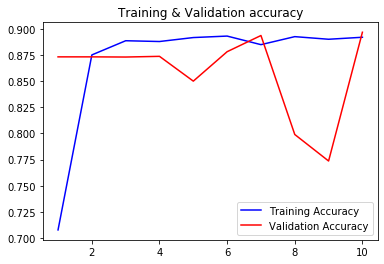

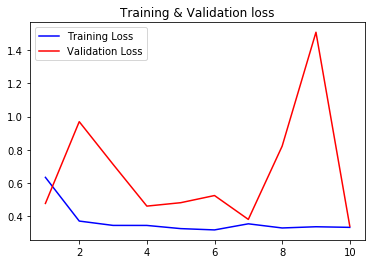

In [21]:
# plot train and val curve
acc = H.history['accuracy']
loss = H.history['loss']

val_acc = H.history['val_accuracy']
val_loss = H.history['val_loss']

epochs = range(1, len(acc) + 1)

# Training and Validation accuracy
plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training & Validation accuracy')
plt.legend()

plt.figure()

# Training and Validation Loss
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training & Validation loss')
plt.legend()

plt.show()


damage: 80.31%
front: 17.74%
minor: 3.92%
moderate: 8.26%
rear: 3.70%
severe: 10.55%
side: 0.69%
whole: 28.69%

damage: 88.05%
front: 8.57%
minor: 0.40%
moderate: 4.37%
rear: 3.69%
severe: 3.66%
side: 1.96%
whole: 8.98%

damage: 14.78%
front: 1.68%
minor: 0.07%
moderate: 0.71%
rear: 0.46%
severe: 5.21%
side: 0.15%
whole: 89.59%

damage: 92.77%
front: 9.95%
minor: 3.48%
moderate: 9.76%
rear: 7.45%
severe: 17.57%
side: 4.98%
whole: 10.81%


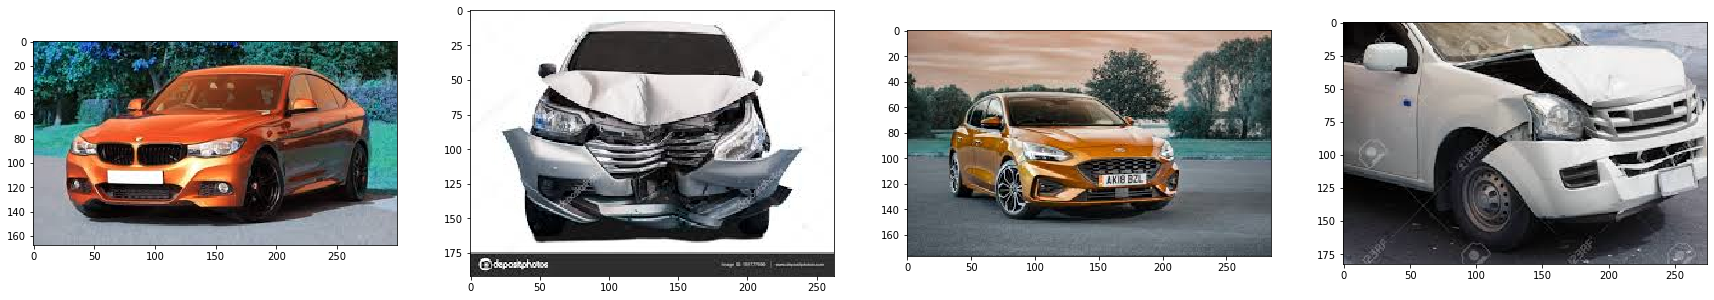

In [22]:
test_dir=os.path.join(CURR_DIR, 'test-set-cars')
test_images = [os.path.join(test_dir, i) for i in os.listdir(test_dir)]
plt.figure(figsize=(30, 20))
columns = 4
for (i, img) in enumerate(test_images):    
    print()
    image = cv2.imread(img)
    output = imutils.resize(image, width=400)
    plt.subplot(5 / columns + 1, columns, i + 1)
    imgplot = plt.imshow(image)
    # pre-process the image for classification
    image = cv2.resize(image, (150, 150))
    image = image.astype("float") / 255.0
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    proba = model.predict(image)[0]
    idxs = np.argsort(proba)[::-1][:2]
    for (i, j) in enumerate(idxs):
        # build the label and draw the label on the image
        label = "{}: {:.2f}%".format(mlb.classes_[j], proba[j] * 100)
        cv2.putText(output, label, (10, (i * 30) + 25), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

        # show the probabilities for each of the individual labels
    for (label, p) in zip(mlb.classes_, proba):
        print("{}: {:.2f}%".format(label, p * 100))
plt.show()